In [16]:
import math as mt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [21]:
def discount(j):
  if j > 2:
    return 1/mt.log(j, 2)
  else:
    return 1

def fn_gamma(G, i, j, k):
   ex = mt.exp(G[k][i] - G[k][j])
   den = (1 + ex)*(1 + ex)
   return ex/den

def fn_theta(G, i, j, k):
  if i != j:
    return fn_gamma(G, i, j, k)
  else:
    return 0

def fn_alpha(g, q_list, m_list, cumulative_m_list, z_list, data_mid):
  num = 0
  den = 0
  for k in range(len(q_list)):
    for i in range(m_list[k]):
      for j in range(m_list[k]):
        ind = cumulative_m_list[k] + i
        r = data_mid.at[ind, 'Relevance']
        val = (2**r - 1)*fn_theta(g, i, j, k)/z_list[k]
        if g[k][j] < g[k][i]:
          num += val
        elif g[k][j] > g[k][i]:
          den += val
  if den != 0 and num != 0:
    return (1/2)*mt.log(num/den)
  elif den == 0:
    print("Division by zero while computing alpha")
    return 0.01
  elif num == 0:
    print("log zero error while computing alpha")
    return 0.01

In [3]:
col_names=["Relevance", 'remqid', 'qid']
for i in range(1, 47):
  col_names.extend(["rem" + str(i), str(i)])
col_names.extend(["docid1", "docid2", "docid"])
data_1_ohsumed = pd.read_csv("OHSUMED.txt", engine ='python', sep=' |:', header=None, names = col_names).sample(n=5000)

rem_cols = ['remqid']
for i in range(1, 47):
  rem_cols.append('rem' + str(i))
rem_cols.extend(['docid1', 'docid2'])
data_2_ohsumed = data_1_ohsumed.drop(columns=rem_cols)

data_2_ohsumed.sort_values(by=['qid'], inplace = True)
data_2_ohsumed.reset_index(drop = True, inplace = True)

data_2_ohsumed

,Relevance,qid,1,2,3,4,5,6,7,8,...,38,39,40,41,42,43,44,45,46,docid
0,0,1,4.0,2.772589,0.444444,0.421442,37.330565,11.431241,37.307017,1.762635,...,0.443894,40.807682,2.784013,20.435618,3.017279,-43.529434,-43.422565,-43.667866,=,NaN
1,0,1,0.0,0.000000,0.000000,0.000000,37.330565,11.431241,37.307017,0.000000,...,0.232302,14.740782,2.208189,15.997534,2.772435,-45.404273,-45.263187,-46.490394,=,NaN
2,0,1,1.0,0.693147,0.333333,0.287682,37.330565,11.431241,37.307017,0.831063,...,0.348572,32.400095,2.135375,20.567738,3.023724,-40.779158,-41.234310,-40.561910,=,NaN
3,0,1,1.0,0.693147,0.500000,0.405465,37.330565,11.431241,37.307017,1.401393,...,0.508375,66.149419,2.625016,19.875335,2.989480,-44.446520,-44.104091,-43.224782,=,NaN
4,0,1,2.0,1.386294,0.250000,0.235566,37.330565,11.431241,37.307017,0.832568,...,0.067215,18.105958,0.498550,7.139850,1.965692,-54.600582,-51.198371,-54.135227,=,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,106,0.0,0.000000,0.000000,0.000000,30.129744,8.809276,30.068215,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-45.278397,-41.694123,-44.235199,=,NaN
4996,0,106,1.0,0.693147,0.100000,0.095310,30.129744,8.809276,30.068215,0.374012,...,0.344724,4.115996,1.007436,6.357552,1.849643,-37.690935,-38.665272,-38.665272,=,NaN
4997,0,106,0.0,0.000000,0.000000,0.000000,30.129744,8.809276,30.068215,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-45.278397,-41.694123,-44.235199,=,NaN
4998,0,106,0.0,0.000000,0.000000,0.000000,30.129744,8.809276,30.068215,0.000000,...,0.357060,92.108270,3.377379,17.740862,2.875871,-28.770251,-29.457707,-29.551181,=,NaN


In [4]:
z_list_ohsumed = []
rem_quer = []
for j in np.unique(data_2_ohsumed['qid']):
  new_df = data_2_ohsumed[data_2_ohsumed['qid'] == j]
  if new_df.shape[0] > 0:
    n0 = len(new_df[new_df['Relevance'] == 0])
    n1 = len(new_df[new_df['Relevance'] == 1])
    n2 = len(new_df[new_df['Relevance'] == 2])
    i = 0
    z = 0
    while i < n2:
      z += 3*discount(i)
      i += 1
    while i < n1 + n2:
      z += discount(i)
      i += 1
    z_list_ohsumed.append(z)
    if z == 0 or new_df.shape[0] < 10:
      rem_quer.append(j)
      data_2_ohsumed = data_2_ohsumed.drop(data_2_ohsumed[data_2_ohsumed['qid'] == j].index)
data_2_ohsumed.reset_index(drop = True, inplace = True)

data_2_ohsumed

,Relevance,qid,1,2,3,4,5,6,7,8,...,38,39,40,41,42,43,44,45,46,docid
0,0,1,4.0,2.772589,0.444444,0.421442,37.330565,11.431241,37.307017,1.762635,...,0.443894,40.807682,2.784013,20.435618,3.017279,-43.529434,-43.422565,-43.667866,=,NaN
1,0,1,0.0,0.000000,0.000000,0.000000,37.330565,11.431241,37.307017,0.000000,...,0.232302,14.740782,2.208189,15.997534,2.772435,-45.404273,-45.263187,-46.490394,=,NaN
2,0,1,1.0,0.693147,0.333333,0.287682,37.330565,11.431241,37.307017,0.831063,...,0.348572,32.400095,2.135375,20.567738,3.023724,-40.779158,-41.234310,-40.561910,=,NaN
3,0,1,1.0,0.693147,0.500000,0.405465,37.330565,11.431241,37.307017,1.401393,...,0.508375,66.149419,2.625016,19.875335,2.989480,-44.446520,-44.104091,-43.224782,=,NaN
4,0,1,2.0,1.386294,0.250000,0.235566,37.330565,11.431241,37.307017,0.832568,...,0.067215,18.105958,0.498550,7.139850,1.965692,-54.600582,-51.198371,-54.135227,=,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4923,0,106,0.0,0.000000,0.000000,0.000000,30.129744,8.809276,30.068215,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-45.278397,-41.694123,-44.235199,=,NaN
4924,0,106,1.0,0.693147,0.100000,0.095310,30.129744,8.809276,30.068215,0.374012,...,0.344724,4.115996,1.007436,6.357552,1.849643,-37.690935,-38.665272,-38.665272,=,NaN
4925,0,106,0.0,0.000000,0.000000,0.000000,30.129744,8.809276,30.068215,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-45.278397,-41.694123,-44.235199,=,NaN
4926,0,106,0.0,0.000000,0.000000,0.000000,30.129744,8.809276,30.068215,0.000000,...,0.357060,92.108270,3.377379,17.740862,2.875871,-28.770251,-29.457707,-29.551181,=,NaN


In [5]:
m_list_ohsumed = []
q_list_ohsumed = []
z_list_ohsumed = []
for j in np.unique(data_2_ohsumed['qid']):
  new_df = data_2_ohsumed[data_2_ohsumed['qid'] == j]
  if new_df.shape[0] > 0:
    q_list_ohsumed.append(j)
    m_list_ohsumed.append(new_df.shape[0])
    n0 = len(new_df[new_df['Relevance'] == 0])
    n1 = len(new_df[new_df['Relevance'] == 1])
    n2 = len(new_df[new_df['Relevance'] == 2])
    i = 0
    z = 0
    while i < n2:
      z += 3*discount(i)
      i += 1
    while i < n1 + n2:
      z += discount(i)
      i += 1
    z_list_ohsumed.append(z)
X_ohsumed = data_2_ohsumed.values[:, 0:47]

cumulative_m_list_ohsumed = [0]
for i in range(1, len(m_list_ohsumed)):
  cumulative_m_list_ohsumed.append(cumulative_m_list_ohsumed[i-1] + m_list_ohsumed[i-1])

print(X_ohsumed)

[[0 1 4.0 ... -43.529434 -43.422565 -43.667866]
 [0 1 0.0 ... -45.404273 -45.263187 -46.490394]
 [0 1 1.0 ... -40.779158 -41.23431 -40.56191]
 ...
 [0 106 0.0 ... -45.278397 -41.694123 -44.235199]
 [0 106 0.0 ... -28.770251 -29.457707 -29.551181]
 [0 106 0.0 ... -41.323156 -40.237247 -40.426558]]


In [6]:
F_ohsumed = []
for k in range(len(q_list_ohsumed)):
  F_ohsumed.append([])
  for i in range(m_list_ohsumed[k]):
     F_ohsumed[k].append(0)

max_iters = 100
iters = 0
while iters < max_iters:
  print("Iteration", iters+1)
  w_ohsumed = []
  y_ohsumed = []
  for k in range(len(q_list_ohsumed)):
    w_ohsumed.append([])
    for i in range(m_list_ohsumed[k]):
      sum = 0
      for j in range(m_list_ohsumed[k]):
        sum += (2**(data_2_ohsumed.at[cumulative_m_list_ohsumed[k] + i, 'Relevance']) - 2**(data_2_ohsumed.at[cumulative_m_list_ohsumed[k] + j, 'Relevance']))*fn_theta(F_ohsumed, i, j, k)
      w_ohsumed[k].append(sum/z_list_ohsumed[k])
      if (sum/z_list_ohsumed[k]) > 0:
        y_ohsumed.append(1)
      else:
        y_ohsumed.append(-1)

  X_train, X_test, y_train, y_test = train_test_split(X_ohsumed, y_ohsumed, test_size=0.2, random_state=10)
  knn = KNeighborsClassifier()
  k_range = list(range(3, 16, 2))
  param_grid = dict(n_neighbors=k_range)
  grid = GridSearchCV(knn, param_grid, cv=5)
  grid.fit(X_train, y_train)
  best_model = grid.best_estimator_
  y_pred_ohsumed = best_model.predict(X_ohsumed)

  f_ohsumed = []
  for k in range(len(q_list_ohsumed)):
    f_ohsumed.append([])
    for i in range(m_list_ohsumed[k]):
      f_ohsumed[k].append(y_pred_ohsumed[cumulative_m_list_ohsumed[k] + i])

  alpha = fn_alpha(f_ohsumed, q_list_ohsumed, m_list_ohsumed, cumulative_m_list_ohsumed, z_list_ohsumed, data_2_ohsumed)

  for k in range(len(q_list_ohsumed)):
    for i in range(m_list_ohsumed[k]):
      F_ohsumed[k][i] += alpha*f_ohsumed[k][i]

  iters += 1

print("Ran 100 iterations")

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteratio

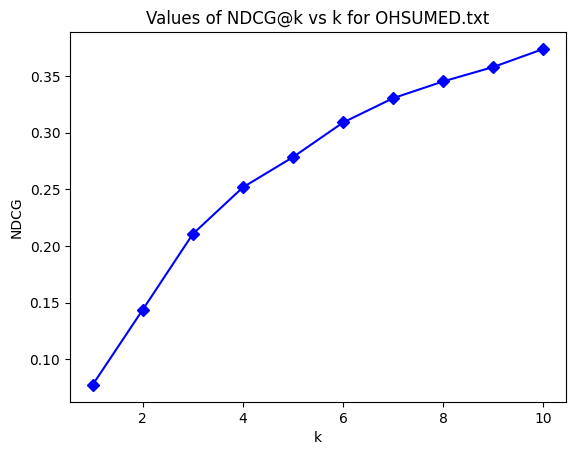

In [7]:
rank_list_ohsumed = []
for k in range(len(q_list_ohsumed)):
    temp_list = []
    sort_list = sorted(F_ohsumed[k], reverse = True)
    count = 0
    while count < 10:
      for i in range(m_list_ohsumed[k]):
        if F_ohsumed[k][i] == sort_list[count]:
          temp_list.append(i)
          count += 1
          if count == 10:
            break
    rank_list_ohsumed.append(temp_list[:10])

NDCG_list_ohsumed = []
for k in range(1, 11):
  num = 0
  for i1 in range(len(q_list_ohsumed)):
    for i2 in range(k):
       num += (2**(data_2_ohsumed.at[cumulative_m_list_ohsumed[i1] + rank_list_ohsumed[i1][i2], 'Relevance']) - 1)*discount(i2)/z_list_ohsumed[i1]
  NDCG_list_ohsumed.append(num/len(q_list_ohsumed))

plt.plot([i for i in range(1, 11)], NDCG_list_ohsumed, color ='b', marker = "D")
plt.title("Values of NDCG@k vs k for OHSUMED.txt")
plt.ylabel('NDCG')
plt.xlabel('k')
plt.show()

Iteration 1
Division by zero while computing alpha
Iteration 2
Division by zero while computing alpha
Iteration 3
Division by zero while computing alpha
Iteration 4
Division by zero while computing alpha
Iteration 5
Division by zero while computing alpha
Iteration 6
Division by zero while computing alpha
Iteration 7
Division by zero while computing alpha
Iteration 8
Division by zero while computing alpha
Iteration 9
Division by zero while computing alpha
Iteration 10
Division by zero while computing alpha
Iteration 11
Division by zero while computing alpha
Iteration 12
Division by zero while computing alpha
Iteration 13
Division by zero while computing alpha
Iteration 14
Division by zero while computing alpha
Iteration 15
Division by zero while computing alpha
Iteration 16
Division by zero while computing alpha
Iteration 17
Division by zero while computing alpha
Iteration 18
Division by zero while computing alpha
Iteration 19
Division by zero while computing alpha
Iteration 20
Division

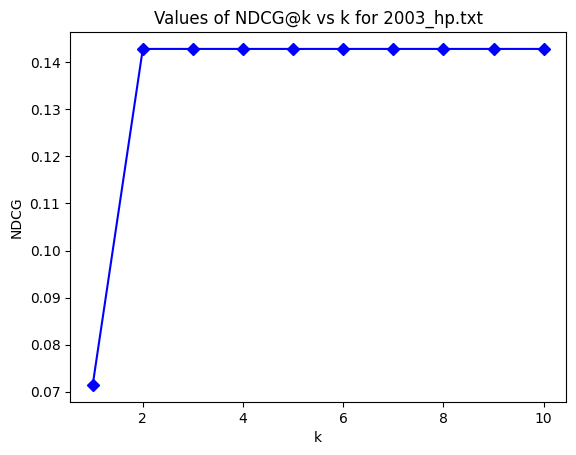

In [24]:
col_names=["Relevance", 'remqid', 'qid']
for i in range(1, 65):
  col_names.extend(["rem" + str(i), str(i)])
col_names.extend(["docid1", "docid2", "docid"])
data_1_2003_hp = pd.read_csv("2003_hp.txt", engine ='python', sep=' |:', header=None, names = col_names).sample(n=5000)

rem_cols = ['remqid']
for i in range(1, 65):
  rem_cols.append('rem' + str(i))
rem_cols.extend(['docid1', 'docid2'])
data_2_2003_hp = data_1_2003_hp.drop(columns=rem_cols)

data_2_2003_hp.sort_values(by=['qid'], inplace = True)
data_2_2003_hp.reset_index(drop = True, inplace = True)

z_list_2003_hp = []
rem_quer = []
for j in np.unique(data_2_2003_hp['qid']):
  new_df = data_2_2003_hp[data_2_2003_hp['qid'] == j]
  if new_df.shape[0] > 0:
    n0 = len(new_df[new_df['Relevance'] == 0])
    n1 = len(new_df[new_df['Relevance'] == 1])
    n2 = len(new_df[new_df['Relevance'] == 2])
    i = 0
    z = 0
    while i < n2:
      z += 3*discount(i)
      i += 1
    while i < n1 + n2:
      z += discount(i)
      i += 1
    z_list_2003_hp.append(z)
    if z == 0 or new_df.shape[0] < 10:
      rem_quer.append(j)
      data_2_2003_hp = data_2_2003_hp.drop(data_2_2003_hp[data_2_2003_hp['qid'] == j].index)
data_2_2003_hp.reset_index(drop = True, inplace = True)

m_list_2003_hp = []
q_list_2003_hp = []
z_list_2003_hp = []
for j in np.unique(data_2_2003_hp['qid']):
  new_df = data_2_2003_hp[data_2_2003_hp['qid'] == j]
  if new_df.shape[0] > 0:
    q_list_2003_hp.append(j)
    m_list_2003_hp.append(new_df.shape[0])
    n0 = len(new_df[new_df['Relevance'] == 0])
    n1 = len(new_df[new_df['Relevance'] == 1])
    n2 = len(new_df[new_df['Relevance'] == 2])
    i = 0
    z = 0
    while i < n2:
      z += 3*discount(i)
      i += 1
    while i < n1 + n2:
      z += discount(i)
      i += 1
    z_list_2003_hp.append(z)
X_2003_hp = data_2_2003_hp.values[:, 0:66]

cumulative_m_list_2003_hp = [0]
for i in range(1, len(m_list_2003_hp)):
  cumulative_m_list_2003_hp.append(cumulative_m_list_2003_hp[i-1] + m_list_2003_hp[i-1])

F_2003_hp = []
for k in range(len(q_list_2003_hp)):
  F_2003_hp.append([])
  for i in range(m_list_2003_hp[k]):
     F_2003_hp[k].append(0)

max_iters = 100
iters = 0
while iters < max_iters:
  print("Iteration", iters+1)
  w_2003_hp = []
  y_2003_hp = []
  for k in range(len(q_list_2003_hp)):
    w_2003_hp.append([])
    for i in range(m_list_2003_hp[k]):
      sum = 0
      for j in range(m_list_2003_hp[k]):
        sum += (2**(data_2_2003_hp.at[cumulative_m_list_2003_hp[k] + i, 'Relevance']) - 2**(data_2_2003_hp.at[cumulative_m_list_2003_hp[k] + j, 'Relevance']))*fn_theta(F_2003_hp, i, j, k)
      w_2003_hp[k].append(sum/z_list_2003_hp[k])
      if (sum/z_list_2003_hp[k]) > 0:
        y_2003_hp.append(1)
      else:
        y_2003_hp.append(-1)

  X_train, X_test, y_train, y_test = train_test_split(X_2003_hp, y_2003_hp, test_size=0.2, random_state=10)
  knn = KNeighborsClassifier()
  k_range = list(range(3, 16, 2))
  param_grid = dict(n_neighbors=k_range)
  grid = GridSearchCV(knn, param_grid, cv=5)
  grid.fit(X_train, y_train)
  best_model = grid.best_estimator_
  y_pred_2003_hp = best_model.predict(X_2003_hp)

  f_2003_hp = []
  for k in range(len(q_list_2003_hp)):
    f_2003_hp.append([])
    for i in range(m_list_2003_hp[k]):
      f_2003_hp[k].append(y_pred_2003_hp[cumulative_m_list_2003_hp[k] + i])

  alpha = fn_alpha(f_2003_hp, q_list_2003_hp, m_list_2003_hp, cumulative_m_list_2003_hp, z_list_2003_hp, data_2_2003_hp)

  for k in range(len(q_list_2003_hp)):
    for i in range(m_list_2003_hp[k]):
      F_2003_hp[k][i] += alpha*f_2003_hp[k][i]

  iters += 1

print("Ran 100 iterations")

rank_list_2003_hp = []
for k in range(len(q_list_2003_hp)):
    temp_list = []
    sort_list = sorted(F_2003_hp[k], reverse = True)
    count = 0
    while count < 10:
      for i in range(m_list_2003_hp[k]):
        if F_2003_hp[k][i] == sort_list[count]:
          temp_list.append(i)
          count += 1
          if count == 10:
            break
    rank_list_2003_hp.append(temp_list[:10])

NDCG_list_2003_hp = []
for k in range(1, 11):
  num = 0
  for i1 in range(len(q_list_2003_hp)):
    for i2 in range(k):
       num += (2**(data_2_2003_hp.at[cumulative_m_list_2003_hp[i1] + rank_list_2003_hp[i1][i2], 'Relevance']) - 1)*discount(i2)/z_list_2003_hp[i1]
  NDCG_list_2003_hp.append(num/len(q_list_2003_hp))

plt.plot([i for i in range(1, 11)], NDCG_list_2003_hp, color ='b', marker = "D")
plt.title("Values of NDCG@k vs k for 2003_hp.txt")
plt.ylabel('NDCG')
plt.xlabel('k')
plt.show()

Iteration 1
Division by zero while computing alpha
Iteration 2
Division by zero while computing alpha
Iteration 3
Division by zero while computing alpha
Iteration 4
Division by zero while computing alpha
Iteration 5
Division by zero while computing alpha
Iteration 6
Division by zero while computing alpha
Iteration 7
Division by zero while computing alpha
Iteration 8
Division by zero while computing alpha
Iteration 9
Division by zero while computing alpha
Iteration 10
Division by zero while computing alpha
Iteration 11
Division by zero while computing alpha
Iteration 12
Division by zero while computing alpha
Iteration 13
Division by zero while computing alpha
Iteration 14
Division by zero while computing alpha
Iteration 15
Division by zero while computing alpha
Iteration 16
Division by zero while computing alpha
Iteration 17
Division by zero while computing alpha
Iteration 18
Division by zero while computing alpha
Iteration 19
Division by zero while computing alpha
Iteration 20
Division

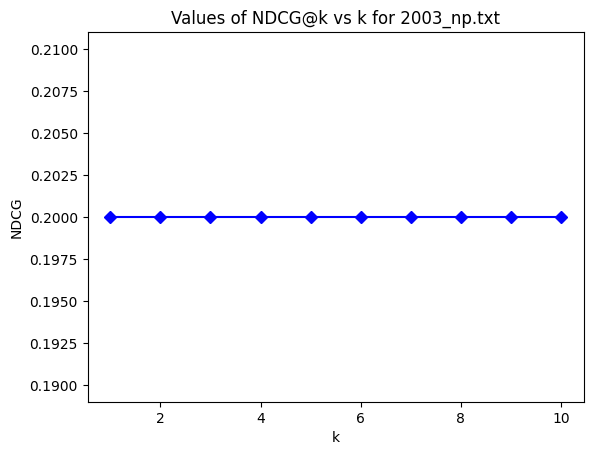

In [10]:
col_names=["Relevance", 'remqid', 'qid']
for i in range(1, 65):
  col_names.extend(["rem" + str(i), str(i)])
col_names.extend(["docid1", "docid2", "docid"])
data_1_2003_np = pd.read_csv("2003_np.txt", engine ='python', sep=' |:', header=None, names = col_names).sample(n=5000)

rem_cols = ['remqid']
for i in range(1, 65):
  rem_cols.append('rem' + str(i))
rem_cols.extend(['docid1', 'docid2'])
data_2_2003_np = data_1_2003_np.drop(columns=rem_cols)

data_2_2003_np.sort_values(by=['qid'], inplace = True)
data_2_2003_np.reset_index(drop = True, inplace = True)

z_list_2003_np = []
rem_quer = []
for j in np.unique(data_2_2003_np['qid']):
  new_df = data_2_2003_np[data_2_2003_np['qid'] == j]
  if new_df.shape[0] > 0:
    n0 = len(new_df[new_df['Relevance'] == 0])
    n1 = len(new_df[new_df['Relevance'] == 1])
    n2 = len(new_df[new_df['Relevance'] == 2])
    i = 0
    z = 0
    while i < n2:
      z += 3*discount(i)
      i += 1
    while i < n1 + n2:
      z += discount(i)
      i += 1
    z_list_2003_np.append(z)
    if z == 0 or new_df.shape[0] < 10:
      rem_quer.append(j)
      data_2_2003_np = data_2_2003_np.drop(data_2_2003_np[data_2_2003_np['qid'] == j].index)
data_2_2003_np.reset_index(drop = True, inplace = True)

m_list_2003_np = []
q_list_2003_np = []
z_list_2003_np = []
for j in np.unique(data_2_2003_np['qid']):
  new_df = data_2_2003_np[data_2_2003_np['qid'] == j]
  if new_df.shape[0] > 0:
    q_list_2003_np.append(j)
    m_list_2003_np.append(new_df.shape[0])
    n0 = len(new_df[new_df['Relevance'] == 0])
    n1 = len(new_df[new_df['Relevance'] == 1])
    n2 = len(new_df[new_df['Relevance'] == 2])
    i = 0
    z = 0
    while i < n2:
      z += 3*discount(i)
      i += 1
    while i < n1 + n2:
      z += discount(i)
      i += 1
    z_list_2003_np.append(z)
X_2003_np = data_2_2003_np.values[:, 0:66]

cumulative_m_list_2003_np = [0]
for i in range(1, len(m_list_2003_np)):
  cumulative_m_list_2003_np.append(cumulative_m_list_2003_np[i-1] + m_list_2003_np[i-1])

F_2003_np = []
for k in range(len(q_list_2003_np)):
  F_2003_np.append([])
  for i in range(m_list_2003_np[k]):
     F_2003_np[k].append(0)

max_iters = 100
iters = 0
while iters < max_iters:
  print("Iteration", iters+1)
  w_2003_np = []
  y_2003_np = []
  for k in range(len(q_list_2003_np)):
    w_2003_np.append([])
    for i in range(m_list_2003_np[k]):
      sum = 0
      for j in range(m_list_2003_np[k]):
        sum += (2**(data_2_2003_np.at[cumulative_m_list_2003_np[k] + i, 'Relevance']) - 2**(data_2_2003_np.at[cumulative_m_list_2003_np[k] + j, 'Relevance']))*fn_theta(F_2003_np, i, j, k)
      w_2003_np[k].append(sum/z_list_2003_np[k])
      if (sum/z_list_2003_np[k]) > 0:
        y_2003_np.append(1)
      else:
        y_2003_np.append(-1)

  X_train, X_test, y_train, y_test = train_test_split(X_2003_np, y_2003_np, test_size=0.2, random_state=10)
  knn = KNeighborsClassifier()
  k_range = list(range(3, 16, 2))
  param_grid = dict(n_neighbors=k_range)
  grid = GridSearchCV(knn, param_grid, cv=5)
  grid.fit(X_train, y_train)
  best_model = grid.best_estimator_
  y_pred_2003_np = best_model.predict(X_2003_np)

  f_2003_np = []
  for k in range(len(q_list_2003_np)):
    f_2003_np.append([])
    for i in range(m_list_2003_np[k]):
      f_2003_np[k].append(y_pred_2003_np[cumulative_m_list_2003_np[k] + i])

  alpha = fn_alpha(f_2003_np, q_list_2003_np, m_list_2003_np, cumulative_m_list_2003_np, z_list_2003_np, data_2_2003_np)

  for k in range(len(q_list_2003_np)):
    for i in range(m_list_2003_np[k]):
      F_2003_np[k][i] += alpha*f_2003_np[k][i]

  iters += 1

print("Ran 100 iterations")

rank_list_2003_np = []
for k in range(len(q_list_2003_np)):
    temp_list = []
    sort_list = sorted(F_2003_np[k], reverse = True)
    count = 0
    while count < 10:
      for i in range(m_list_2003_np[k]):
        if F_2003_np[k][i] == sort_list[count]:
          temp_list.append(i)
          count += 1
          if count == 10:
            break
    rank_list_2003_np.append(temp_list[:10])

NDCG_list_2003_np = []
for k in range(1, 11):
  num = 0
  for i1 in range(len(q_list_2003_np)):
    for i2 in range(k):
       num += (2**(data_2_2003_np.at[cumulative_m_list_2003_np[i1] + rank_list_2003_np[i1][i2], 'Relevance']) - 1)*discount(i2)/z_list_2003_np[i1]
  NDCG_list_2003_np.append(num/len(q_list_2003_np))

plt.plot([i for i in range(1, 11)], NDCG_list_2003_np, color ='b', marker = "D")
plt.title("Values of NDCG@k vs k for 2003_np.txt")
plt.ylabel('NDCG')
plt.xlabel('k')
plt.show()

Iteration 1
log zero error while computing alpha
Iteration 2
log zero error while computing alpha
Iteration 3
log zero error while computing alpha
Iteration 4
log zero error while computing alpha
Iteration 5
log zero error while computing alpha
Iteration 6
log zero error while computing alpha
Iteration 7
log zero error while computing alpha
Iteration 8
log zero error while computing alpha
Iteration 9
log zero error while computing alpha
Iteration 10
log zero error while computing alpha
Iteration 11
log zero error while computing alpha
Iteration 12
log zero error while computing alpha
Iteration 13
log zero error while computing alpha
Iteration 14
log zero error while computing alpha
Iteration 15
log zero error while computing alpha
Iteration 16
log zero error while computing alpha
Iteration 17
log zero error while computing alpha
Iteration 18
log zero error while computing alpha
Iteration 19
log zero error while computing alpha
Iteration 20
log zero error while computing alpha
Iteration

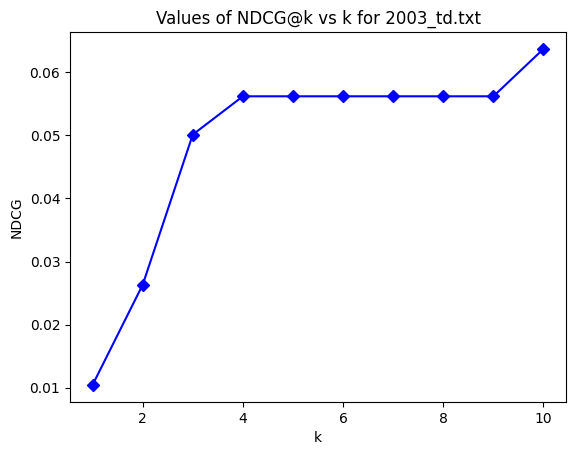

In [22]:
col_names=["Relevance", 'remqid', 'qid']
for i in range(1, 65):
  col_names.extend(["rem" + str(i), str(i)])
col_names.extend(["docid1", "docid2", "docid"])
data_1_2003_td = pd.read_csv("2003_td.txt", engine ='python', sep=' |:', header=None, names = col_names).sample(n=5000)

rem_cols = ['remqid']
for i in range(1, 65):
  rem_cols.append('rem' + str(i))
rem_cols.extend(['docid1', 'docid2'])
data_2_2003_td = data_1_2003_td.drop(columns=rem_cols)

data_2_2003_td.sort_values(by=['qid'], inplace = True)
data_2_2003_td.reset_index(drop = True, inplace = True)

z_list_2003_td = []
rem_quer = []
for j in np.unique(data_2_2003_td['qid']):
  new_df = data_2_2003_td[data_2_2003_td['qid'] == j]
  if new_df.shape[0] > 0:
    n0 = len(new_df[new_df['Relevance'] == 0])
    n1 = len(new_df[new_df['Relevance'] == 1])
    n2 = len(new_df[new_df['Relevance'] == 2])
    i = 0
    z = 0
    while i < n2:
      z += 3*discount(i)
      i += 1
    while i < n1 + n2:
      z += discount(i)
      i += 1
    z_list_2003_td.append(z)
    if z == 0 or new_df.shape[0] < 10:
      rem_quer.append(j)
      data_2_2003_td = data_2_2003_td.drop(data_2_2003_td[data_2_2003_td['qid'] == j].index)
data_2_2003_td.reset_index(drop = True, inplace = True)

m_list_2003_td = []
q_list_2003_td = []
z_list_2003_td = []
for j in np.unique(data_2_2003_td['qid']):
  new_df = data_2_2003_td[data_2_2003_td['qid'] == j]
  if new_df.shape[0] > 0:
    q_list_2003_td.append(j)
    m_list_2003_td.append(new_df.shape[0])
    n0 = len(new_df[new_df['Relevance'] == 0])
    n1 = len(new_df[new_df['Relevance'] == 1])
    n2 = len(new_df[new_df['Relevance'] == 2])
    i = 0
    z = 0
    while i < n2:
      z += 3*discount(i)
      i += 1
    while i < n1 + n2:
      z += discount(i)
      i += 1
    z_list_2003_td.append(z)
X_2003_td = data_2_2003_td.values[:, 0:66]

cumulative_m_list_2003_td = [0]
for i in range(1, len(m_list_2003_td)):
  cumulative_m_list_2003_td.append(cumulative_m_list_2003_td[i-1] + m_list_2003_td[i-1])

F_2003_td = []
for k in range(len(q_list_2003_td)):
  F_2003_td.append([])
  for i in range(m_list_2003_td[k]):
     F_2003_td[k].append(0)

max_iters = 100
iters = 0
while iters < max_iters:
  print("Iteration", iters+1)
  w_2003_td = []
  y_2003_td = []
  for k in range(len(q_list_2003_td)):
    w_2003_td.append([])
    for i in range(m_list_2003_td[k]):
      sum = 0
      for j in range(m_list_2003_td[k]):
        sum += (2**(data_2_2003_td.at[cumulative_m_list_2003_td[k] + i, 'Relevance']) - 2**(data_2_2003_td.at[cumulative_m_list_2003_td[k] + j, 'Relevance']))*fn_theta(F_2003_td, i, j, k)
      w_2003_td[k].append(sum/z_list_2003_td[k])
      if (sum/z_list_2003_td[k]) > 0:
        y_2003_td.append(1)
      else:
        y_2003_td.append(-1)

  X_train, X_test, y_train, y_test = train_test_split(X_2003_td, y_2003_td, test_size=0.2, random_state=10)
  knn = KNeighborsClassifier()
  k_range = list(range(3, 16, 2))
  param_grid = dict(n_neighbors=k_range)
  grid = GridSearchCV(knn, param_grid, cv=5)
  grid.fit(X_train, y_train)
  best_model = grid.best_estimator_
  y_pred_2003_td = best_model.predict(X_2003_td)

  f_2003_td = []
  for k in range(len(q_list_2003_td)):
    f_2003_td.append([])
    for i in range(m_list_2003_td[k]):
      f_2003_td[k].append(y_pred_2003_td[cumulative_m_list_2003_td[k] + i])

  alpha = fn_alpha(f_2003_td, q_list_2003_td, m_list_2003_td, cumulative_m_list_2003_td, z_list_2003_td, data_2_2003_td)

  for k in range(len(q_list_2003_td)):
    for i in range(m_list_2003_td[k]):
      F_2003_td[k][i] += alpha*f_2003_td[k][i]

  iters += 1

print("Ran 100 iterations")

rank_list_2003_td = []
for k in range(len(q_list_2003_td)):
    temp_list = []
    sort_list = sorted(F_2003_td[k], reverse = True)
    count = 0
    while count < 10:
      for i in range(m_list_2003_td[k]):
        if F_2003_td[k][i] == sort_list[count]:
          temp_list.append(i)
          count += 1
          if count == 10:
            break
    rank_list_2003_td.append(temp_list[:10])

NDCG_list_2003_td = []
for k in range(1, 11):
  num = 0
  for i1 in range(len(q_list_2003_td)):
    for i2 in range(k):
       num += (2**(data_2_2003_td.at[cumulative_m_list_2003_td[i1] + rank_list_2003_td[i1][i2], 'Relevance']) - 1)*discount(i2)/z_list_2003_td[i1]
  NDCG_list_2003_td.append(num/len(q_list_2003_td))

plt.plot([i for i in range(1, 11)], NDCG_list_2003_td, color ='b', marker = "D")
plt.title("Values of NDCG@k vs k for 2003_td.txt")
plt.ylabel('NDCG')
plt.xlabel('k')
plt.show()

Iteration 1
Division by zero while computing alpha
Iteration 2
Division by zero while computing alpha
Iteration 3
Division by zero while computing alpha
Iteration 4
Division by zero while computing alpha
Iteration 5
Division by zero while computing alpha
Iteration 6
Division by zero while computing alpha
Iteration 7
Division by zero while computing alpha
Iteration 8
Division by zero while computing alpha
Iteration 9
Division by zero while computing alpha
Iteration 10
Division by zero while computing alpha
Iteration 11
Division by zero while computing alpha
Iteration 12
Division by zero while computing alpha
Iteration 13
Division by zero while computing alpha
Iteration 14
Division by zero while computing alpha
Iteration 15
Division by zero while computing alpha
Iteration 16
Division by zero while computing alpha
Iteration 17
Division by zero while computing alpha
Iteration 18
Division by zero while computing alpha
Iteration 19
Division by zero while computing alpha
Iteration 20
Division

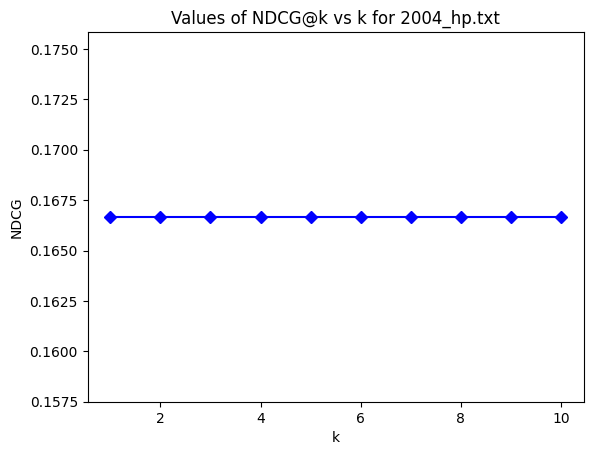

In [20]:
col_names=["Relevance", 'remqid', 'qid']
for i in range(1, 65):
  col_names.extend(["rem" + str(i), str(i)])
col_names.extend(["docid1", "docid2", "docid"])
data_1_2004_hp = pd.read_csv("2004_hp.txt", engine ='python', sep=' |:', header=None, names = col_names).sample(n=5000)

rem_cols = ['remqid']
for i in range(1, 65):
  rem_cols.append('rem' + str(i))
rem_cols.extend(['docid1', 'docid2'])
data_2_2004_hp = data_1_2004_hp.drop(columns=rem_cols)

data_2_2004_hp.sort_values(by=['qid'], inplace = True)
data_2_2004_hp.reset_index(drop = True, inplace = True)

for i in range(data_2_2004_hp.shape[0]):
  data_2_2004_hp.at[i, 'qid'] = data_2_2004_hp.at[i, 'qid'].split('-')[1]

z_list_2004_hp = []
rem_quer = []
for j in np.unique(data_2_2004_hp['qid']):
  new_df = data_2_2004_hp[data_2_2004_hp['qid'] == j]
  if new_df.shape[0] > 0:
    n0 = len(new_df[new_df['Relevance'] == 0])
    n1 = len(new_df[new_df['Relevance'] == 1])
    n2 = len(new_df[new_df['Relevance'] == 2])
    i = 0
    z = 0
    while i < n2:
      z += 3*discount(i)
      i += 1
    while i < n1 + n2:
      z += discount(i)
      i += 1
    z_list_2004_hp.append(z)
    if z == 0 or new_df.shape[0] < 10:
      rem_quer.append(j)
      data_2_2004_hp = data_2_2004_hp.drop(data_2_2004_hp[data_2_2004_hp['qid'] == j].index)
data_2_2004_hp.reset_index(drop = True, inplace = True)

m_list_2004_hp = []
q_list_2004_hp = []
z_list_2004_hp = []
for j in np.unique(data_2_2004_hp['qid']):
  new_df = data_2_2004_hp[data_2_2004_hp['qid'] == j]
  if new_df.shape[0] > 0:
    q_list_2004_hp.append(j)
    m_list_2004_hp.append(new_df.shape[0])
    n0 = len(new_df[new_df['Relevance'] == 0])
    n1 = len(new_df[new_df['Relevance'] == 1])
    n2 = len(new_df[new_df['Relevance'] == 2])
    i = 0
    z = 0
    while i < n2:
      z += 3*discount(i)
      i += 1
    while i < n1 + n2:
      z += discount(i)
      i += 1
    z_list_2004_hp.append(z)
X_2004_hp = data_2_2004_hp.values[:, 0:66]

cumulative_m_list_2004_hp = [0]
for i in range(1, len(m_list_2004_hp)):
  cumulative_m_list_2004_hp.append(cumulative_m_list_2004_hp[i-1] + m_list_2004_hp[i-1])

F_2004_hp = []
for k in range(len(q_list_2004_hp)):
  F_2004_hp.append([])
  for i in range(m_list_2004_hp[k]):
     F_2004_hp[k].append(0)

max_iters = 100
iters = 0
while iters < max_iters:
  print("Iteration", iters+1)
  w_2004_hp = []
  y_2004_hp = []
  for k in range(len(q_list_2004_hp)):
    w_2004_hp.append([])
    for i in range(m_list_2004_hp[k]):
      sum = 0
      for j in range(m_list_2004_hp[k]):
        sum += (2**(data_2_2004_hp.at[cumulative_m_list_2004_hp[k] + i, 'Relevance']) - 2**(data_2_2004_hp.at[cumulative_m_list_2004_hp[k] + j, 'Relevance']))*fn_theta(F_2004_hp, i, j, k)
      w_2004_hp[k].append(sum/z_list_2004_hp[k])
      if (sum/z_list_2004_hp[k]) > 0:
        y_2004_hp.append(1)
      else:
        y_2004_hp.append(-1)

  X_train, X_test, y_train, y_test = train_test_split(X_2004_hp, y_2004_hp, test_size=0.2, random_state=10)
  knn = KNeighborsClassifier()
  k_range = list(range(3, 16, 2))
  param_grid = dict(n_neighbors=k_range)
  grid = GridSearchCV(knn, param_grid, cv=5)
  grid.fit(X_train, y_train)
  best_model = grid.best_estimator_
  y_pred_2004_hp = best_model.predict(X_2004_hp)

  f_2004_hp = []
  for k in range(len(q_list_2004_hp)):
    f_2004_hp.append([])
    for i in range(m_list_2004_hp[k]):
      f_2004_hp[k].append(y_pred_2004_hp[cumulative_m_list_2004_hp[k] + i])

  alpha = fn_alpha(f_2004_hp, q_list_2004_hp, m_list_2004_hp, cumulative_m_list_2004_hp, z_list_2004_hp, data_2_2004_hp)

  for k in range(len(q_list_2004_hp)):
    for i in range(m_list_2004_hp[k]):
      F_2004_hp[k][i] += alpha*f_2004_hp[k][i]

  iters += 1

print("Ran 100 iterations")

rank_list_2004_hp = []
for k in range(len(q_list_2004_hp)):
    temp_list = []
    sort_list = sorted(F_2004_hp[k], reverse = True)
    count = 0
    while count < 10:
      for i in range(m_list_2004_hp[k]):
        if F_2004_hp[k][i] == sort_list[count]:
          temp_list.append(i)
          count += 1
          if count == 10:
            break
    rank_list_2004_hp.append(temp_list[:10])

NDCG_list_2004_hp = []
for k in range(1, 11):
  num = 0
  for i1 in range(len(q_list_2004_hp)):
    for i2 in range(k):
       num += (2**(data_2_2004_hp.at[cumulative_m_list_2004_hp[i1] + rank_list_2004_hp[i1][i2], 'Relevance']) - 1)*discount(i2)/z_list_2004_hp[i1]
  NDCG_list_2004_hp.append(num/len(q_list_2004_hp))

plt.plot([i for i in range(1, 11)], NDCG_list_2004_hp, color ='b', marker = "D")
plt.title("Values of NDCG@k vs k for 2004_hp.txt")
plt.ylabel('NDCG')
plt.xlabel('k')
plt.show()

Iteration 1
Division by zero while computing alpha
Iteration 2
Division by zero while computing alpha
Iteration 3
Division by zero while computing alpha
Iteration 4
Division by zero while computing alpha
Iteration 5
Division by zero while computing alpha
Iteration 6
Division by zero while computing alpha
Iteration 7
Division by zero while computing alpha
Iteration 8
Division by zero while computing alpha
Iteration 9
Division by zero while computing alpha
Iteration 10
Division by zero while computing alpha
Iteration 11
Division by zero while computing alpha
Iteration 12
Division by zero while computing alpha
Iteration 13
Division by zero while computing alpha
Iteration 14
Division by zero while computing alpha
Iteration 15
Division by zero while computing alpha
Iteration 16
Division by zero while computing alpha
Iteration 17
Division by zero while computing alpha
Iteration 18
Division by zero while computing alpha
Iteration 19
Division by zero while computing alpha
Iteration 20
Division

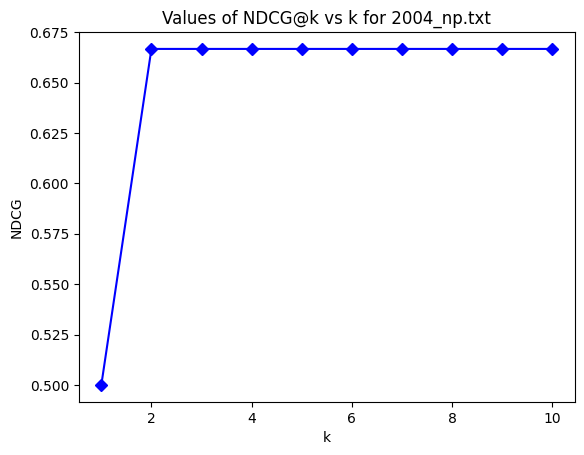

In [ ]:
col_names=["Relevance", 'remqid', 'qid']
for i in range(1, 65):
  col_names.extend(["rem" + str(i), str(i)])
col_names.extend(["docid1", "docid2", "docid"])
data_1_2004_np = pd.read_csv("2004_np.txt", engine ='python', sep=' |:', header=None, names = col_names).sample(n=5000)

rem_cols = ['remqid']
for i in range(1, 65):
  rem_cols.append('rem' + str(i))
rem_cols.extend(['docid1', 'docid2'])
data_2_2004_np = data_1_2004_np.drop(columns=rem_cols)

data_2_2004_np.sort_values(by=['qid'], inplace = True)
data_2_2004_np.reset_index(drop = True, inplace = True)

for i in range(data_2_2004_np.shape[0]):
  data_2_2004_np.at[i, 'qid'] = data_2_2004_np.at[i, 'qid'].split('-')[1]

z_list_2004_np = []
rem_quer = []
for j in np.unique(data_2_2004_np['qid']):
  new_df = data_2_2004_np[data_2_2004_np['qid'] == j]
  if new_df.shape[0] > 0:
    n0 = len(new_df[new_df['Relevance'] == 0])
    n1 = len(new_df[new_df['Relevance'] == 1])
    n2 = len(new_df[new_df['Relevance'] == 2])
    i = 0
    z = 0
    while i < n2:
      z += 3*discount(i)
      i += 1
    while i < n1 + n2:
      z += discount(i)
      i += 1
    z_list_2004_np.append(z)
    if z == 0 or new_df.shape[0] < 10:
      rem_quer.append(j)
      data_2_2004_np = data_2_2004_np.drop(data_2_2004_np[data_2_2004_np['qid'] == j].index)
data_2_2004_np.reset_index(drop = True, inplace = True)

m_list_2004_np = []
q_list_2004_np = []
z_list_2004_np = []
for j in np.unique(data_2_2004_np['qid']):
  new_df = data_2_2004_np[data_2_2004_np['qid'] == j]
  if new_df.shape[0] > 0:
    q_list_2004_np.append(j)
    m_list_2004_np.append(new_df.shape[0])
    n0 = len(new_df[new_df['Relevance'] == 0])
    n1 = len(new_df[new_df['Relevance'] == 1])
    n2 = len(new_df[new_df['Relevance'] == 2])
    i = 0
    z = 0
    while i < n2:
      z += 3*discount(i)
      i += 1
    while i < n1 + n2:
      z += discount(i)
      i += 1
    z_list_2004_np.append(z)
X_2004_np = data_2_2004_np.values[:, 0:66]

cumulative_m_list_2004_np = [0]
for i in range(1, len(m_list_2004_np)):
  cumulative_m_list_2004_np.append(cumulative_m_list_2004_np[i-1] + m_list_2004_np[i-1])

F_2004_np = []
for k in range(len(q_list_2004_np)):
  F_2004_np.append([])
  for i in range(m_list_2004_np[k]):
     F_2004_np[k].append(0)

max_iters = 100
iters = 0
while iters < max_iters:
  print("Iteration", iters+1)
  w_2004_np = []
  y_2004_np = []
  for k in range(len(q_list_2004_np)):
    w_2004_np.append([])
    for i in range(m_list_2004_np[k]):
      sum = 0
      for j in range(m_list_2004_np[k]):
        sum += (2**(data_2_2004_np.at[cumulative_m_list_2004_np[k] + i, 'Relevance']) - 2**(data_2_2004_np.at[cumulative_m_list_2004_np[k] + j, 'Relevance']))*fn_theta(F_2004_np, i, j, k)
      w_2004_np[k].append(sum/z_list_2004_np[k])
      if (sum/z_list_2004_np[k]) > 0:
        y_2004_np.append(1)
      else:
        y_2004_np.append(-1)

  X_train, X_test, y_train, y_test = train_test_split(X_2004_np, y_2004_np, test_size=0.2, random_state=10)
  knn = KNeighborsClassifier()
  k_range = list(range(3, 16, 2))
  param_grid = dict(n_neighbors=k_range)
  grid = GridSearchCV(knn, param_grid, cv=5)
  grid.fit(X_train, y_train)
  best_model = grid.best_estimator_
  y_pred_2004_np = best_model.predict(X_2004_np)

  f_2004_np = []
  for k in range(len(q_list_2004_np)):
    f_2004_np.append([])
    for i in range(m_list_2004_np[k]):
      f_2004_np[k].append(y_pred_2004_np[cumulative_m_list_2004_np[k] + i])

  alpha = fn_alpha(f_2004_np, q_list_2004_np, m_list_2004_np, cumulative_m_list_2004_np, z_list_2004_np, data_2_2004_np)

  for k in range(len(q_list_2004_np)):
    for i in range(m_list_2004_np[k]):
      F_2004_np[k][i] += alpha*f_2004_np[k][i]

  iters += 1

print("Ran 100 iterations")

rank_list_2004_np = []
for k in range(len(q_list_2004_np)):
    temp_list = []
    sort_list = sorted(F_2004_np[k], reverse = True)
    count = 0
    while count < 10:
      for i in range(m_list_2004_np[k]):
        if F_2004_np[k][i] == sort_list[count]:
          temp_list.append(i)
          count += 1
          if count == 10:
            break
    rank_list_2004_np.append(temp_list[:10])

NDCG_list_2004_np = []
for k in range(1, 11):
  num = 0
  for i1 in range(len(q_list_2004_np)):
    for i2 in range(k):
       num += (2**(data_2_2004_np.at[cumulative_m_list_2004_np[i1] + rank_list_2004_np[i1][i2], 'Relevance']) - 1)*discount(i2)/z_list_2004_np[i1]
  NDCG_list_2004_np.append(num/len(q_list_2004_np))

plt.plot([i for i in range(1, 11)], NDCG_list_2004_np, color ='b', marker = "D")
plt.title("Values of NDCG@k vs k for 2004_np.txt")
plt.ylabel('NDCG')
plt.xlabel('k')
plt.show()

Iteration 1
Division by zero while computing alpha
Iteration 2
Division by zero while computing alpha
Iteration 3
Division by zero while computing alpha
Iteration 4
Division by zero while computing alpha
Iteration 5
Division by zero while computing alpha
Iteration 6
Division by zero while computing alpha
Iteration 7
Division by zero while computing alpha
Iteration 8
Division by zero while computing alpha
Iteration 9
Division by zero while computing alpha
Iteration 10
Division by zero while computing alpha
Iteration 11
Division by zero while computing alpha
Iteration 12
Division by zero while computing alpha
Iteration 13
Division by zero while computing alpha
Iteration 14
Division by zero while computing alpha
Iteration 15
Division by zero while computing alpha
Iteration 16
Division by zero while computing alpha
Iteration 17
Division by zero while computing alpha
Iteration 18
Division by zero while computing alpha
Iteration 19
Division by zero while computing alpha
Iteration 20
Division

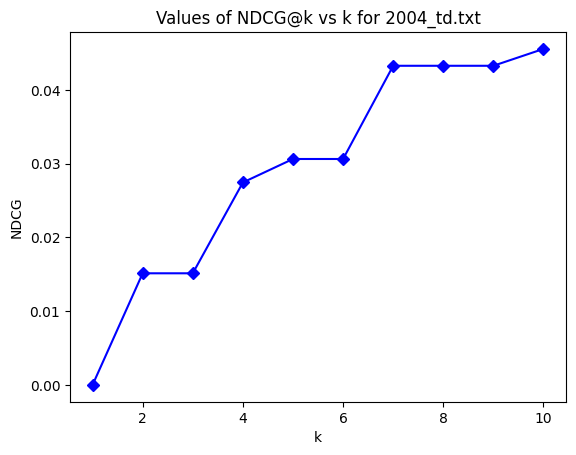

In [14]:
col_names=["Relevance", 'remqid', 'qid']
for i in range(1, 65):
  col_names.extend(["rem" + str(i), str(i)])
col_names.extend(["docid1", "docid2", "docid"])
data_1_2004_td = pd.read_csv("2004_td.txt", engine ='python', sep=' |:', header=None, names = col_names).sample(n=5000)

rem_cols = ['remqid']
for i in range(1, 65):
  rem_cols.append('rem' + str(i))
rem_cols.extend(['docid1', 'docid2'])
data_2_2004_td = data_1_2004_td.drop(columns=rem_cols)

data_2_2004_td.sort_values(by=['qid'], inplace = True)
data_2_2004_td.reset_index(drop = True, inplace = True)

for i in range(data_2_2004_td.shape[0]):
  data_2_2004_td.at[i, 'qid'] = data_2_2004_td.at[i, 'qid'].split('-')[1]

z_list_2004_td = []
rem_quer = []
for j in np.unique(data_2_2004_td['qid']):
  new_df = data_2_2004_td[data_2_2004_td['qid'] == j]
  if new_df.shape[0] > 0:
    n0 = len(new_df[new_df['Relevance'] == 0])
    n1 = len(new_df[new_df['Relevance'] == 1])
    n2 = len(new_df[new_df['Relevance'] == 2])
    i = 0
    z = 0
    while i < n2:
      z += 3*discount(i)
      i += 1
    while i < n1 + n2:
      z += discount(i)
      i += 1
    z_list_2004_td.append(z)
    if z == 0 or new_df.shape[0] < 10:
      rem_quer.append(j)
      data_2_2004_td = data_2_2004_td.drop(data_2_2004_td[data_2_2004_td['qid'] == j].index)
data_2_2004_td.reset_index(drop = True, inplace = True)

m_list_2004_td = []
q_list_2004_td = []
z_list_2004_td = []
for j in np.unique(data_2_2004_td['qid']):
  new_df = data_2_2004_td[data_2_2004_td['qid'] == j]
  if new_df.shape[0] > 0:
    q_list_2004_td.append(j)
    m_list_2004_td.append(new_df.shape[0])
    n0 = len(new_df[new_df['Relevance'] == 0])
    n1 = len(new_df[new_df['Relevance'] == 1])
    n2 = len(new_df[new_df['Relevance'] == 2])
    i = 0
    z = 0
    while i < n2:
      z += 3*discount(i)
      i += 1
    while i < n1 + n2:
      z += discount(i)
      i += 1
    z_list_2004_td.append(z)
X_2004_td = data_2_2004_td.values[:, 0:66]

cumulative_m_list_2004_td = [0]
for i in range(1, len(m_list_2004_td)):
  cumulative_m_list_2004_td.append(cumulative_m_list_2004_td[i-1] + m_list_2004_td[i-1])

F_2004_td = []
for k in range(len(q_list_2004_td)):
  F_2004_td.append([])
  for i in range(m_list_2004_td[k]):
     F_2004_td[k].append(0)

max_iters = 100
iters = 0
while iters < max_iters:
  print("Iteration", iters+1)
  w_2004_td = []
  y_2004_td = []
  for k in range(len(q_list_2004_td)):
    w_2004_td.append([])
    for i in range(m_list_2004_td[k]):
      sum = 0
      for j in range(m_list_2004_td[k]):
        sum += (2**(data_2_2004_td.at[cumulative_m_list_2004_td[k] + i, 'Relevance']) - 2**(data_2_2004_td.at[cumulative_m_list_2004_td[k] + j, 'Relevance']))*fn_theta(F_2004_td, i, j, k)
      w_2004_td[k].append(sum/z_list_2004_td[k])
      if (sum/z_list_2004_td[k]) > 0:
        y_2004_td.append(1)
      else:
        y_2004_td.append(-1)

  X_train, X_test, y_train, y_test = train_test_split(X_2004_td, y_2004_td, test_size=0.2, random_state=10)
  knn = KNeighborsClassifier()
  k_range = list(range(3, 16, 2))
  param_grid = dict(n_neighbors=k_range)
  grid = GridSearchCV(knn, param_grid, cv=5)
  grid.fit(X_train, y_train)
  best_model = grid.best_estimator_
  y_pred_2004_td = best_model.predict(X_2004_td)

  f_2004_td = []
  for k in range(len(q_list_2004_td)):
    f_2004_td.append([])
    for i in range(m_list_2004_td[k]):
      f_2004_td[k].append(y_pred_2004_td[cumulative_m_list_2004_td[k] + i])

  alpha = fn_alpha(f_2004_td, q_list_2004_td, m_list_2004_td, cumulative_m_list_2004_td, z_list_2004_td, data_2_2004_td)

  for k in range(len(q_list_2004_td)):
    for i in range(m_list_2004_td[k]):
      F_2004_td[k][i] += alpha*f_2004_td[k][i]

  iters += 1

print("Ran 100 iterations")

rank_list_2004_td = []
for k in range(len(q_list_2004_td)):
    temp_list = []
    sort_list = sorted(F_2004_td[k], reverse = True)
    count = 0
    while count < 10:
      for i in range(m_list_2004_td[k]):
        if F_2004_td[k][i] == sort_list[count]:
          temp_list.append(i)
          count += 1
          if count == 10:
            break
    rank_list_2004_td.append(temp_list[:10])

NDCG_list_2004_td = []
for k in range(1, 11):
  num = 0
  for i1 in range(len(q_list_2004_td)):
    for i2 in range(k):
       num += (2**(data_2_2004_td.at[cumulative_m_list_2004_td[i1] + rank_list_2004_td[i1][i2], 'Relevance']) - 1)*discount(i2)/z_list_2004_td[i1]
  NDCG_list_2004_td.append(num/len(q_list_2004_td))

plt.plot([i for i in range(1, 11)], NDCG_list_2004_td, color ='b', marker = "D")
plt.title("Values of NDCG@k vs k for 2004_td.txt")
plt.ylabel('NDCG')
plt.xlabel('k')
plt.show()